# MAP & NIRS Data Aggregation

In [534]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import zoll
from utils import nirs
from utils import misc
from utils.autoscale import autoscale

In [535]:
# parameters
case_id = 1
step_id = 2

In [536]:
case_str = str(case_id).zfill(5)
output_file = f'output/{case_str}_{step_id}.csv'
amend_file = 'amend/' + case_str + '_a2.csv'

In [537]:
zoll_filename = 'zoll' + case_str + '.json'
nirs_filename = 'nirs' + case_str + '.csv'
json = zoll.LoadJSON("data/" + zoll_filename)

In [538]:
# load pulse waveform from channel 1
bp_df, bp_samplerate = zoll.LoadWaveform(json, hide_starttime=True, discard_by_status=False, channel=1)

Channel 1: CO2 kPa, Waveform
WaveType:  48
Duration:         4050.12 s
Total samples:     506265      Discarded:       0
Sample rate:          125 1/s  Sample time:  8000 μs
Min:                 -227      Max:           339



In [539]:
# for MAP
def ComputeAverage(waveform, window, samplerate, win_type=None):
    win = window * samplerate
    return waveform.rolling(win, win_type=win_type).mean()

bp_df.rename(columns={'BadSignal': 'Bad_MAP_auto'}, inplace=True)

In [540]:
# compute MAP using a 10 second sliding average
bp_df['MAP'] = ComputeAverage(bp_df['Waveform'], 10, bp_samplerate)

In [541]:
nirs_df = nirs.LoadCSV("data/" + nirs_filename,
                       discard_by_status=False)

In [542]:
amend_df = pd.read_csv(amend_file,
                       sep = ';',
                       na_values = ['--', ' '],
                       parse_dates = ['Time'])

In [543]:
nirs_df['Mark'] = amend_df['Mark'].array
nirs_df['Bad_rSO2_manual'] = amend_df['HuonoSignaali2'].array

In [544]:
# make room for possible MAP values recorded before start of NIRS signal
first_bp_timestamp = bp_df.index[0].round('1s')
first_nirs_timestamp = nirs_df.index[0]
new_timestamp = first_nirs_timestamp
while (new_timestamp > first_bp_timestamp):
    new_timestamp -= pd.Timedelta(seconds=1)
    new_row = pd.DataFrame(data=[[0, 0]], columns=['Bad_rSO2_auto', 'Bad_rSO2_manual'], index=[new_timestamp])
    nirs_df = pd.concat([new_row, nirs_df], ignore_index=False)
nirs_df = nirs_df.rename_axis('Time')

In [545]:
# make room for possible MAP values recorded after end of NIRS signal
last_bp_timestamp = bp_df.index[-1].round('1s')
last_nirs_timestamp = nirs_df.index[-1]
new_timestamp = last_nirs_timestamp
while (new_timestamp < last_bp_timestamp):
    new_timestamp += pd.Timedelta(seconds=1)
    new_row = pd.DataFrame(data=[[0, 0]], columns=['Bad_rSO2_auto', 'Bad_rSO2_manual'], index=[new_timestamp])
    nirs_df = pd.concat([nirs_df, new_row], ignore_index=False)
nirs_df = nirs_df.rename_axis('Time')

In [546]:
# merge with NIRS (rSO2) data
df = pd.merge_asof(nirs_df[['rSO2', 'Mark', 'Bad_rSO2_auto', 'Bad_rSO2_manual']], bp_df[['MAP', 'Bad_MAP_auto']], on='Time', direction='nearest')

In [547]:
df.replace({'Mark': '',
            'Mark': np.nan}, '0', inplace=True)
df['Mark'] = df['Mark'].astype(int)

In [548]:
misc.NormalizeTime(df)

df['T'] = df['Time'].apply(lambda x: x.strftime('%H:%M:%S'))
df['Time'] = df['T']

In [549]:
df[['Time', 'MAP', 'rSO2', 'Mark', 'Bad_rSO2_auto', 'Bad_rSO2_manual', 'Bad_MAP_auto']].to_csv(output_file, na_rep='-', index_label='id')

In [550]:
df['Time'] = pd.to_datetime(df['Time'])
misc.NormalizeTime(df)
df.set_index('Time', inplace=True)

In [551]:
map_ranges = misc.GetRanges(df, 'Bad_MAP_auto')
nirs_ranges = misc.GetRanges(df, 'Bad_rSO2_auto')

In [552]:
mark_timestamp = df.loc[df['Mark'] == 1].index[0]

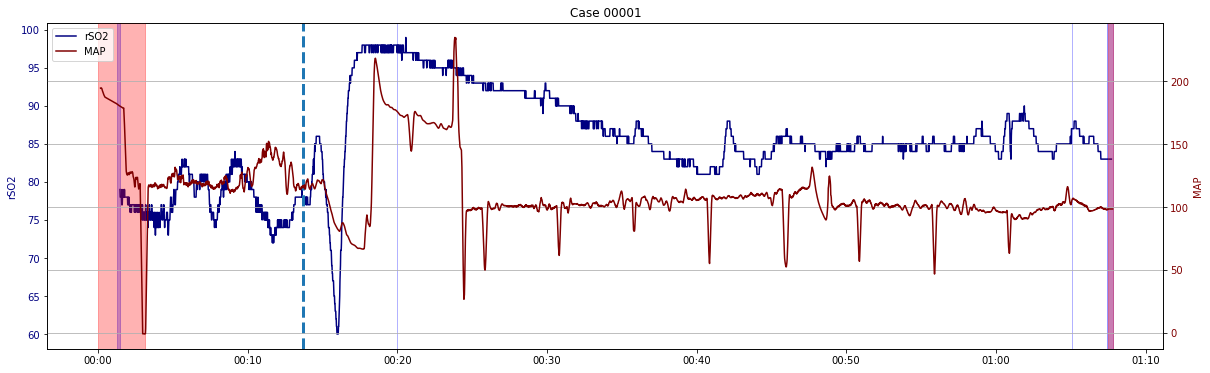

In [553]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('rSO2', color='navy')
line1 = ax1.plot(df.index, df['rSO2'], color='navy', label='rSO2')
ax1.tick_params(axis='y', labelcolor='navy')
ax2 = ax1.twinx()
ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
ax2.set_ylabel('MAP', color='maroon')
line2 = ax2.plot(df.index, df['MAP'], color='maroon', label='MAP')
ax2.tick_params(axis='y', labelcolor='maroon')
lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper left')
ax2.grid()
plt.title(f'Case {case_str}')
for r in nirs_ranges:
    ax1.axvspan(r[0], r[1], alpha=0.3, color='blue')
for r in map_ranges:
    ax2.axvspan(r[0], r[1], alpha=0.3, color='red')
ax1.axvline(mark_timestamp, linestyle='--', linewidth=3)
plt.autoscale(enable=True, axis="x", tight=True)
plt.savefig(f'reports/images/2_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)
plt.show()